In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import pandas as pd

In [3]:
od.download(
    "https://www.kaggle.com/datasets/moltean/fruits")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nagasreenivasulu
Your Kaggle Key: ··········


100%|██████████| 1.28G/1.28G [00:32<00:00, 42.5MB/s]


In [24]:
# Libraries for data preprocessing
import pandas as pd
import numpy as np

# Libraries for data vis
import matplotlib.pyplot  as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import keras.utils as image

# Libraries for file and direc. operatioins
import glob
import os
import random

# Libraries for DL model
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
# Define training and test folders
train_path = '/content/fruits/fruits-360-original-size/fruits-360-original-size/Training'
test_path = '/content/fruits/fruits-360-original-size/fruits-360-original-size/Test'

In [26]:
# Countin total labels
def count_labels(path):
    label_count = 0
    for _, dirs, _ in os.walk(path):
        label_count += len(dirs)
        break # only counts the top and exit the loop
    return label_count

num_label = count_labels(train_path)
print(f'Number of classes: {num_label}')

Number of classes: 24


In [27]:
# Get a list of all labels within training
labels = [label for label in os.listdir(train_path) if os.path.isdir(os.path.join(train_path,label))]

# Sort the labels by alph.
sorted_labels = sorted(labels)

print('Sorted Labels:')
for label in sorted_labels:
    print(label)

Sorted Labels:
apple_6
apple_braeburn_1
apple_crimson_snow_1
apple_golden_1
apple_golden_2
apple_golden_3
apple_granny_smith_1
apple_hit_1
apple_pink_lady_1
apple_red_1
apple_red_2
apple_red_3
apple_red_delicios_1
apple_red_yellow_1
apple_rotten_1
cabbage_white_1
carrot_1
cucumber_1
cucumber_3
eggplant_violet_1
pear_1
pear_3
zucchini_1
zucchini_dark_1


In [29]:
train_name = []
train_img_name = []

for i in os.listdir(train_path):
    for train_img_fname in os.listdir(train_path+'/'+i):
        train_name.append(i)
        train_img_name.append(train_img_fname)

In [30]:
df_train = pd.DataFrame(train_name, columns=['fruits_name'])
df_train['fruist_img'] = train_img_name

df_train.head()

,fruits_name,fruist_img
0,apple_hit_1,r0_68.jpg
1,apple_hit_1,r1_128.jpg
2,apple_hit_1,r1_306.jpg
3,apple_hit_1,r2_200.jpg
4,apple_hit_1,r1_150.jpg


In [35]:
df_train_nuniques = df_train['fruits_name'].value_counts().reset_index()
df_train_nuniques.columns = ['fruits_name', 'count']
df_train_nuniques.head()

,fruits_name,count
0,apple_hit_1,468
1,pear_1,326
2,apple_braeburn_1,320
3,apple_granny_smith_1,320
4,apple_rotten_1,319


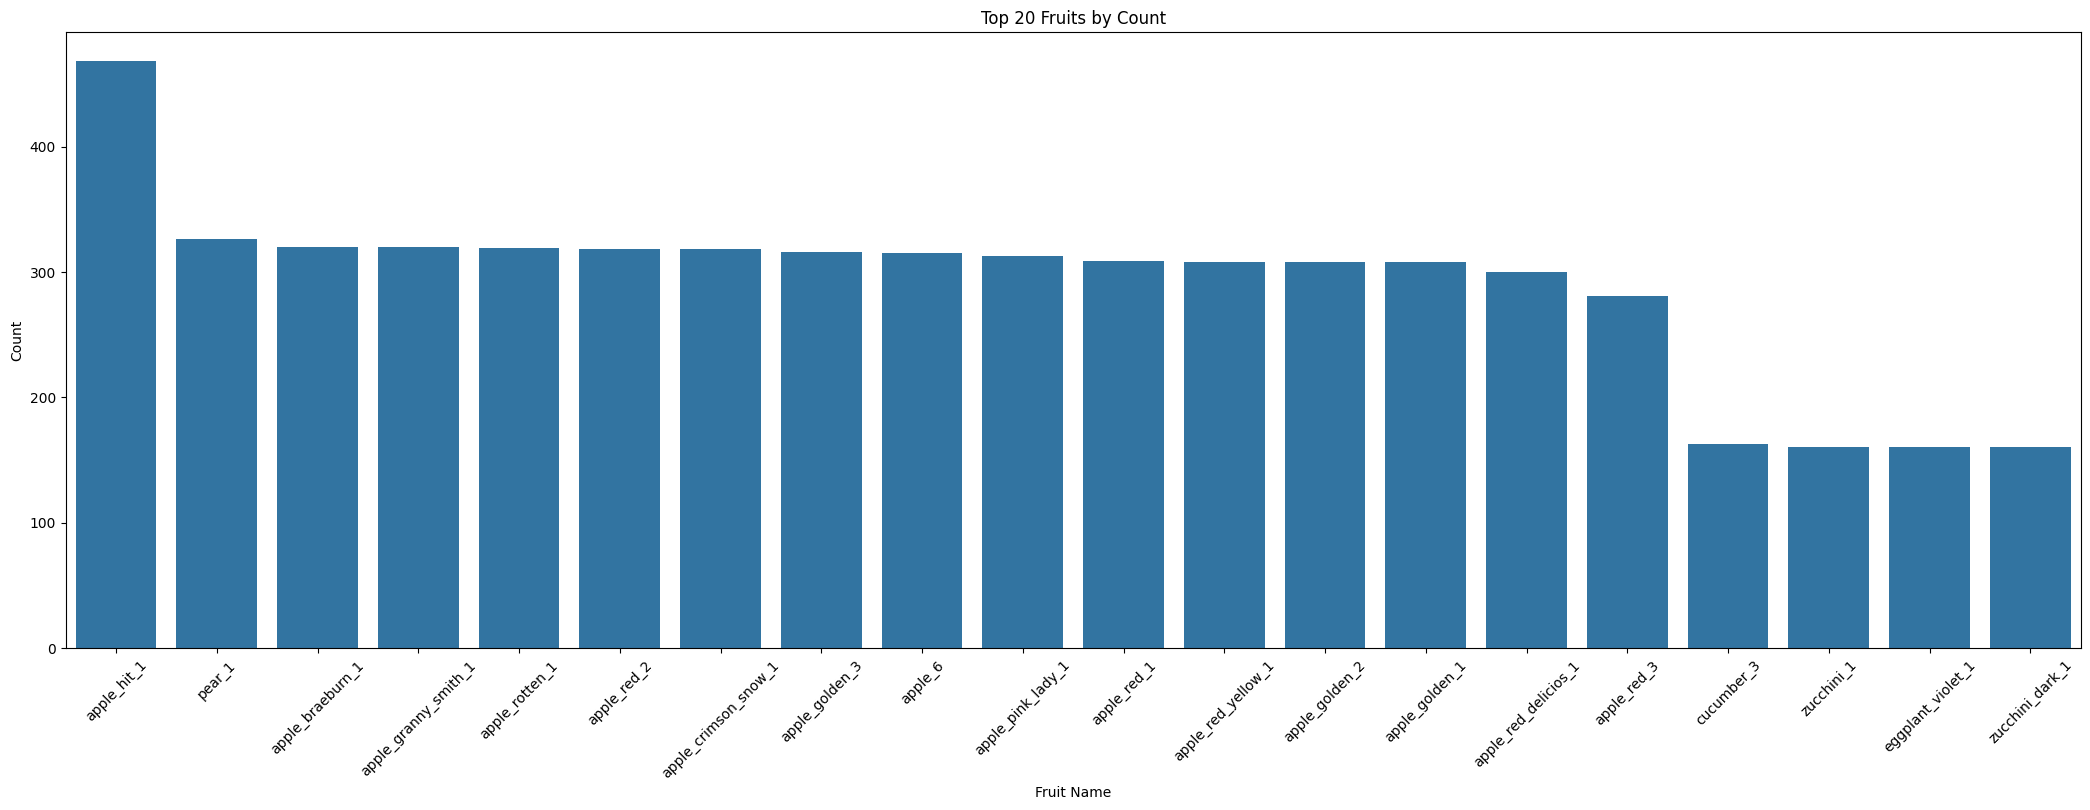

In [36]:
df_sorted = df_train_nuniques.sort_values(by='count', ascending=False)

plt.figure(figsize=(26,8))
sns.barplot(x=df_sorted['fruits_name'].iloc[:20],
            y=df_sorted['count'].iloc[:20])
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xlabel('Fruit Name')
plt.ylabel('Count')
plt.title('Top 20 Fruits by Count')
plt.show()

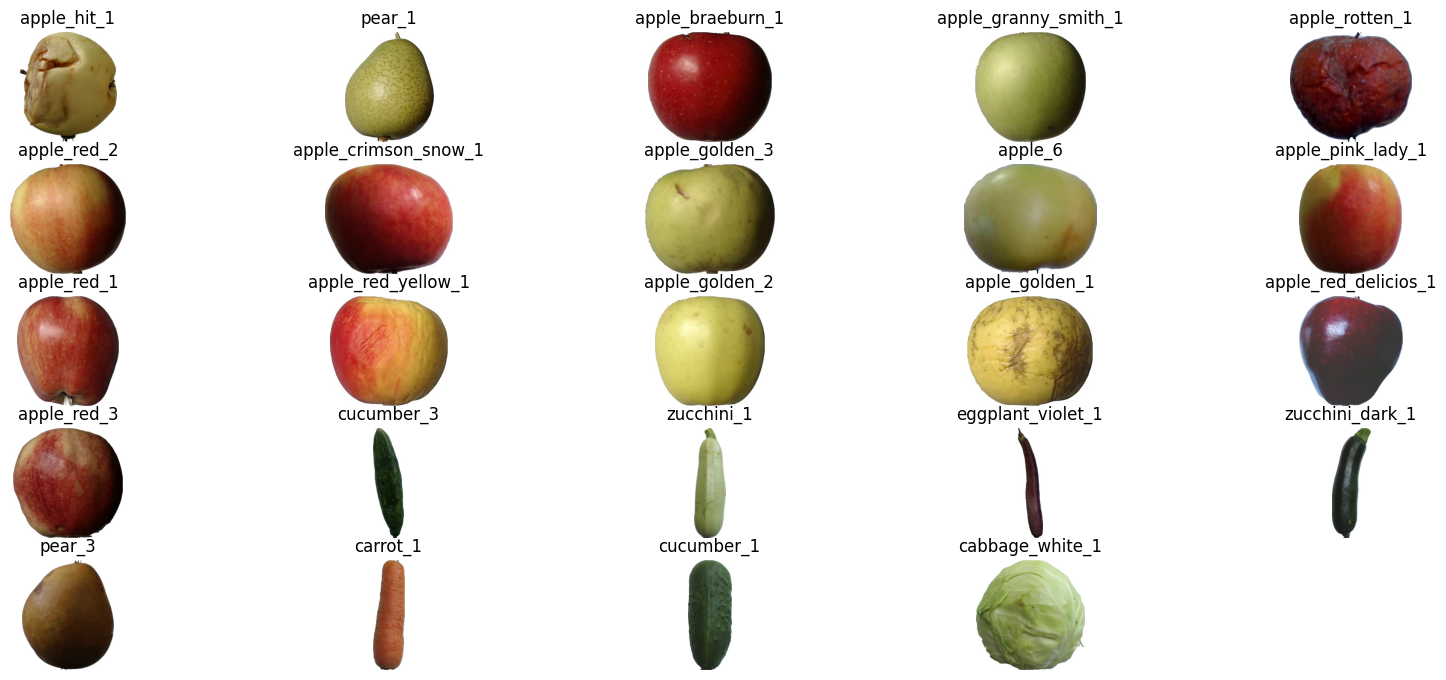

In [41]:
fig = plt.figure(figsize=(20,10))

for i in range(24):
    ax = fig.add_subplot(6,5,i+1, xticks=[], yticks=[])
    plt.title(df_train_nuniques['fruits_name'][i])
    plt.axis('off')
    file = os.listdir(train_path + '/' + df_train_nuniques['fruits_name'][i])

    img_name = file[0]
    ax.imshow(image.load_img(train_path + '/' + df_train_nuniques['fruits_name'][i] + '/' + img_name))

In [42]:
train_datagen = ImageDataGenerator(rescale=1./255.0,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
train_set = train_datagen.flow_from_directory(train_path,
                                             target_size=(100,100),
                                             batch_size = 64,
                                             class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                             target_size=(100,100),
                                             batch_size = 64,
                                             class_mode = 'categorical')

Found 6231 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


In [44]:
n_class = len(train_set.class_indices)
print('Number of class:', n_class)

Number of class: 24


In [45]:
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'apple_6', 1: 'apple_braeburn_1', 2: 'apple_crimson_snow_1', 3: 'apple_golden_1', 4: 'apple_golden_2', 5: 'apple_golden_3', 6: 'apple_granny_smith_1', 7: 'apple_hit_1', 8: 'apple_pink_lady_1', 9: 'apple_red_1', 10: 'apple_red_2', 11: 'apple_red_3', 12: 'apple_red_delicios_1', 13: 'apple_red_yellow_1', 14: 'apple_rotten_1', 15: 'cabbage_white_1', 16: 'carrot_1', 17: 'cucumber_1', 18: 'cucumber_3', 19: 'eggplant_violet_1', 20: 'pear_1', 21: 'pear_3', 22: 'zucchini_1', 23: 'zucchini_dark_1'}


In [47]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=(100,100,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(64, (3,3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(128, (3,3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(24, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [48]:
hist = model.fit(train_set,
                steps_per_epoch = 50,
                epochs = 50,
                validation_data = test_set,
                validation_steps = 200)

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 2.8579 - accuracy: 0.1187

50/50 [==============================] - 26s 430ms/step - loss: 2.8579 - accuracy: 0.1187 - val_loss: 2.3212 - val_accuracy: 0.2138
Epoch 2/50
50/50 [==============================] - 16s 330ms/step - loss: 2.0962 - accuracy: 0.2809
Epoch 3/50
50/50 [==============================] - 15s 301ms/step - loss: 1.5046 - accuracy: 0.4700
Epoch 4/50
50/50 [==============================] - 16s 325ms/step - loss: 1.1599 - accuracy: 0.5881
Epoch 5/50
50/50 [==============================] - 15s 297ms/step - loss: 0.9442 - accuracy: 0.6648
Epoch 6/50
50/50 [==============================] - 15s 295ms/step - loss: 0.8060 - accuracy: 0.7075
Epoch 7/50
50/50 [==============================] - 15s 304ms/step - loss: 0.6587 - accuracy: 0.7631
Epoch 8/50
50/50 [==============================] - 16s 309ms/step - loss: 0.6237 - accuracy: 0.7819
Epoch 9/50
50/50 [==============================] - 15s 293ms/step - loss: 0.5329 - accuracy: 0.8230
Epoch 10/50
50/50 [==============================] - 15s 297

In [49]:
model.save("fruits_classification.keras")
model.save("fruits_classification.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 7ms/step


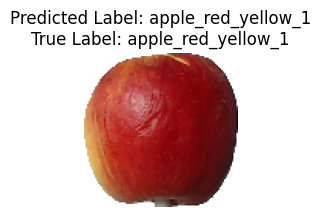

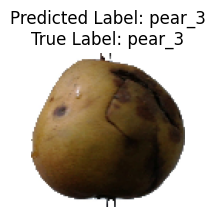

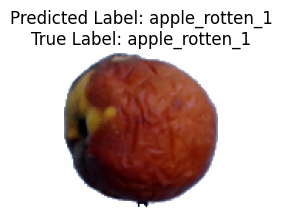

In [51]:
test_images, test_labels = next(test_set)
predictions = model.predict(test_images)

for i in range(3):
    predicted_label_index = np.argmax(predictions[i])
    predicted_label = labels[predicted_label_index]
    true_label_index = np.argmax(test_labels[i])
    true_label = labels[true_label_index]

    plt.figure(figsize=(2,2))
    plt.imshow(test_images[i])
    plt.title(f'Predicted Label: {predicted_label}\nTrue Label: {true_label}')
    plt.axis('off')
    plt.show()